In [16]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
print(tf.__version__)

from scipy.io import readsav

1.14.0


In [104]:
import matplotlib as m
fig_size = (8,6)
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'font.size': 12,
          'legend.fontsize': 12,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 125,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [233]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(25, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd-1)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 5
    waveNumd  = 100
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Conv1D(40, (5,), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(60, (5,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(100, (5,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(60,(5,), activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(40,(5,), activation='relu')(y)

    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation=tf.nn.relu)(y)
    y2 = layers.Add()([y,y1[:,:,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

      #layers.GlobalAveragePooling1D(),
      #layers.Dense(20, activation='sigmoid'),    
      #layers.Dense(10, activation='sigmoid'),
    x = layers.Dense(waveNumd,activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_dense_model():
    waveNumd = 100
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dropout(0.4)(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
   # y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd)(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

## Preview of some of the FISS data.

(100, 250, 502)


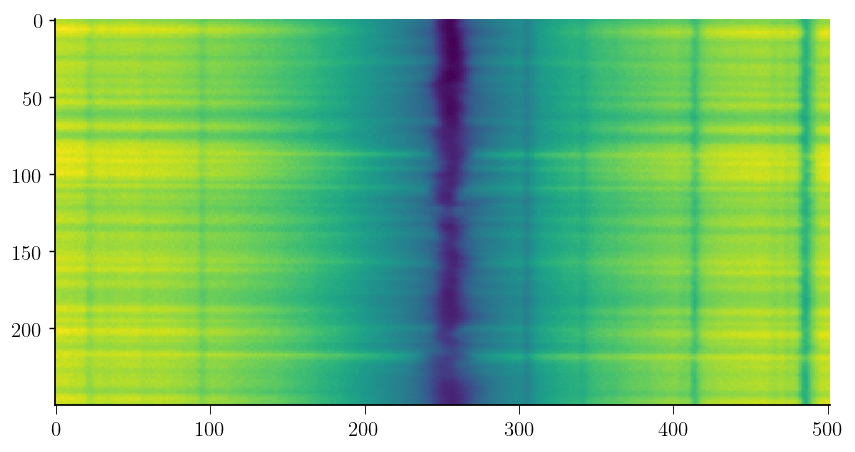

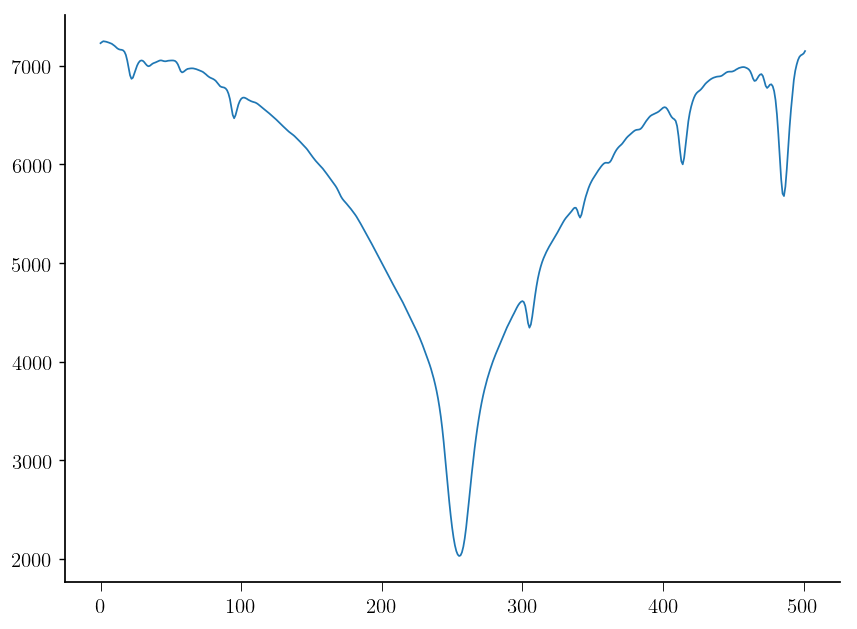

(100, 250, 502)


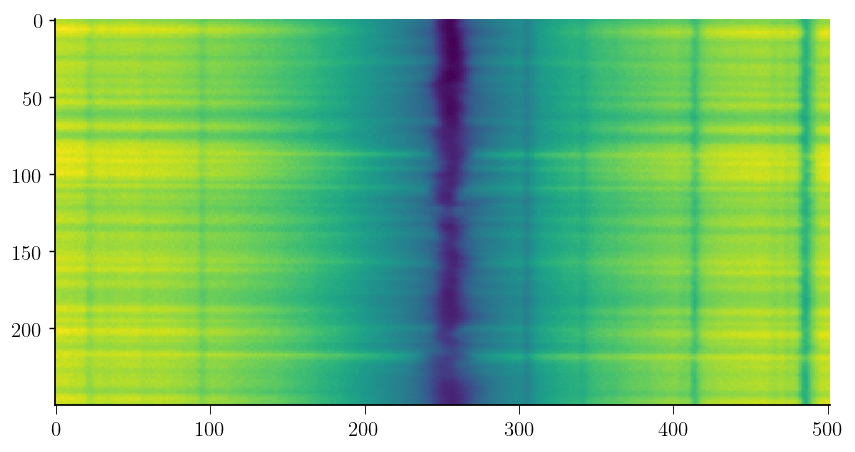

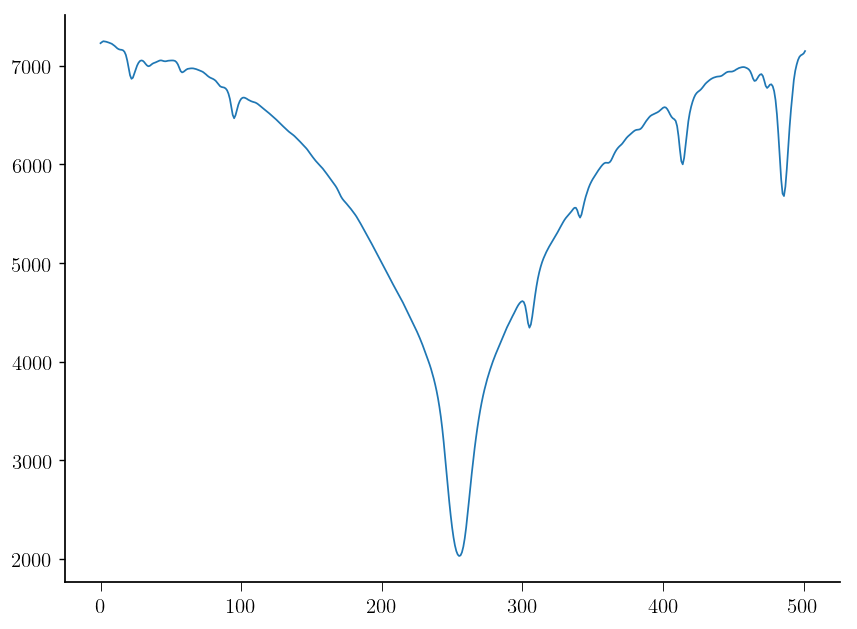

In [148]:
haData = load_spectral_profiles('','FISS_20160622_174421_A1.fts')
haSpectralRes = 0.0190416632507
print(a.shape)
plt.imshow(a[0,:,:])
plt.show()

plt.plot(np.mean(a[:,:,:],axis=(0,1)))
plt.show()

caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106
print(a.shape)
plt.imshow(a[0,:,:])
plt.show()

plt.plot(np.mean(a[:,:,:],axis=(0,1)))

## Convolve the FISS data with some PSFs

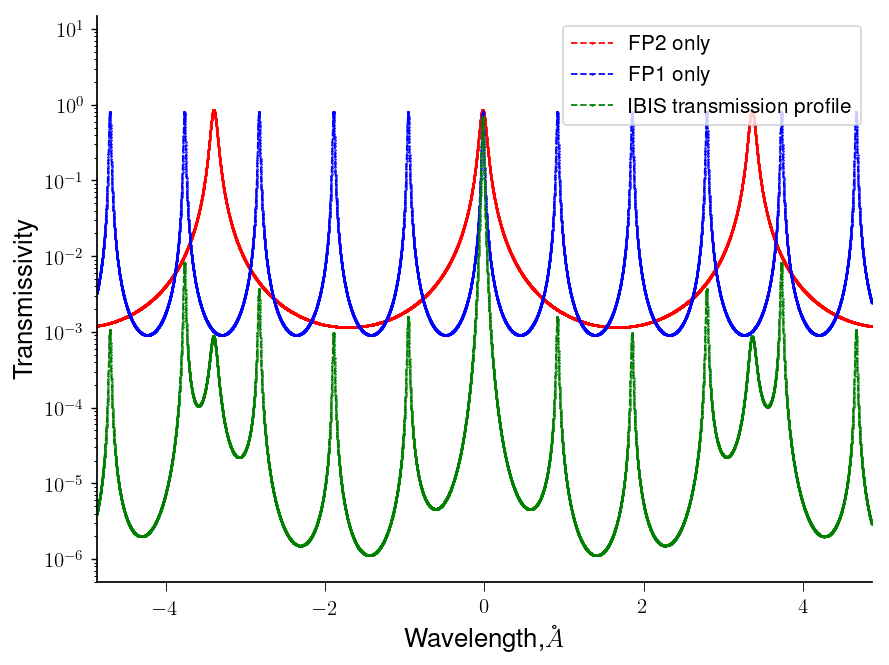

In [118]:
ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
wave = np.linspace(-24,24,num=48001)
plt.figure(figsize=(8,6))
plt.plot(wave,ab['ibis_fp2_profile_6563'],'r.--',label='FP2 only',markersize=1)
plt.plot(wave,ab['ibis_fp1_profile_6563'],'b.--',label='FP1 only',markersize=1)
plt.plot(wave,ab['ibis_fp1_profile_6563']*ab['ibis_fp2_profile_6563'],'g.--'
         ,markersize=1,label='IBIS transmission profile')
plt.legend()
plt.yscale('log')
plt.ylabel('Transmissivity')
plt.ylim(5e-7,15)
plt.xlabel('Wavelength,$\\AA$')
plt.xlim(-4.864,4.864)
plt.show()

### Convolve the whole FISS FOV

Shape of b is 502
Shape of a[0,0,:] is 502


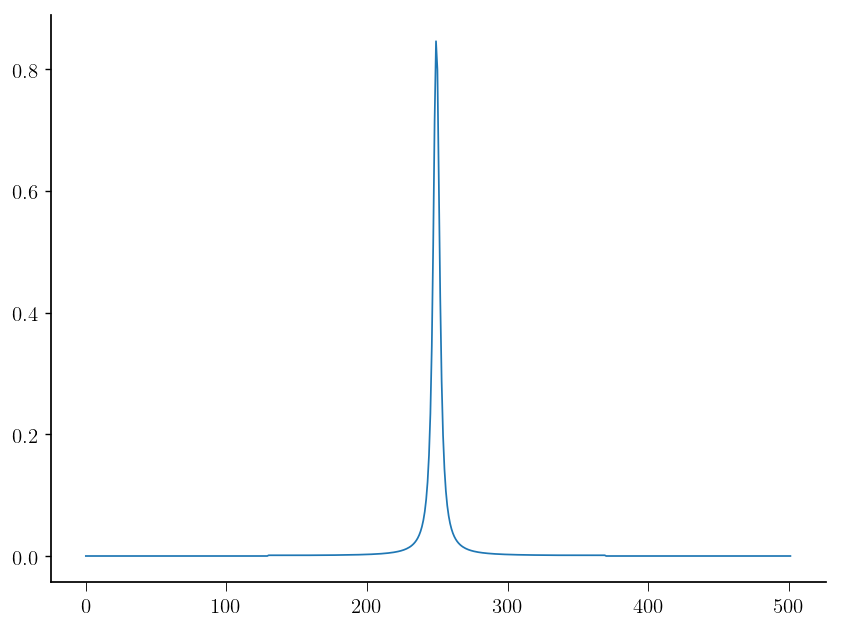

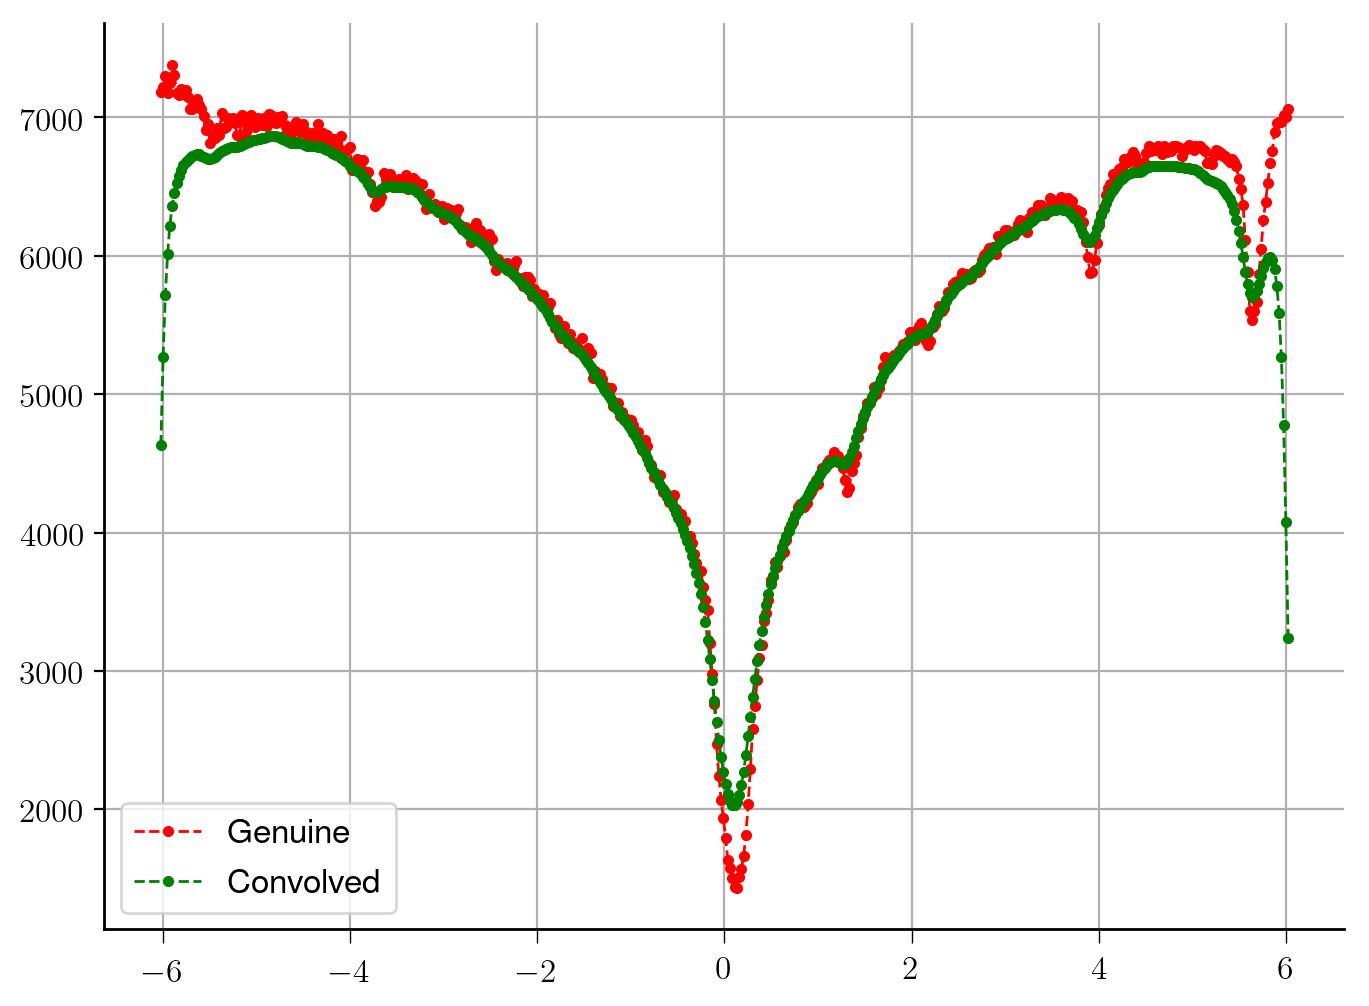

In [147]:
Nlambda      = 502
dlambda      = 0.024
trans_filter = produce_FP_transmission_peak(4,0,Nlambda,2,6563)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)

trans_filter[0:130] = 0
trans_filter[370:] = 0

trans_filter_total = np.sum(trans_filter)

plt.plot(trans_filter)
#plt.grid()
#plt.yscale('log')
#plt.show()
plt.figure(dpi=200)
b = np.convolve(a[0,0,:],trans_filter/trans_filter_total,mode='same')
print("Shape of b is %d"%b.shape)
print("Shape of a[0,0,:] is %d"%a[0,0,:].shape)
plt.plot(wave,(a[0,0,:]),'r.--',label='Genuine')
plt.plot(wave,(b[0:Nlambda]),'g.--',label='Convolved')
plt.legend()
plt.grid()
plt.show()

### Convolve the Ha and Ca data with the wide FP Transmission profile

502
(100, 250, 502)


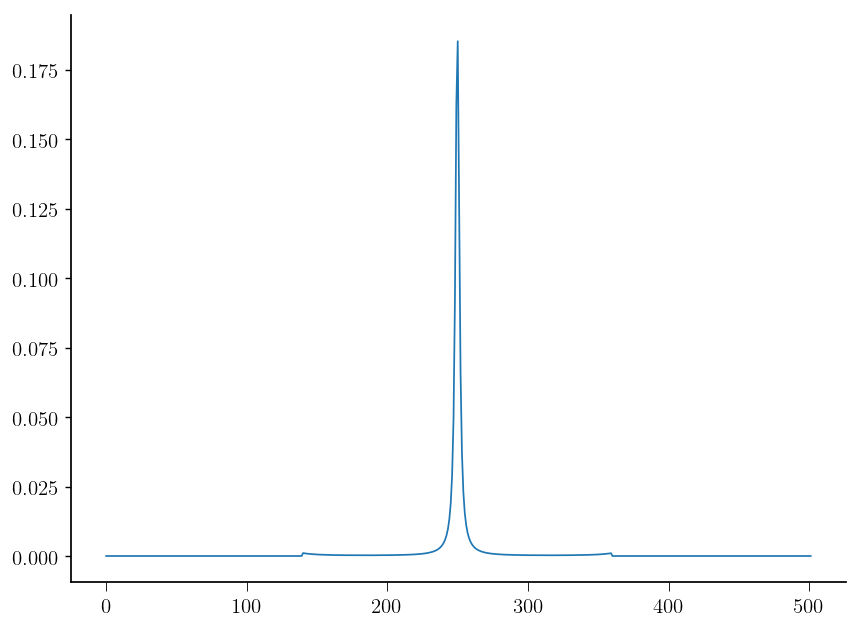

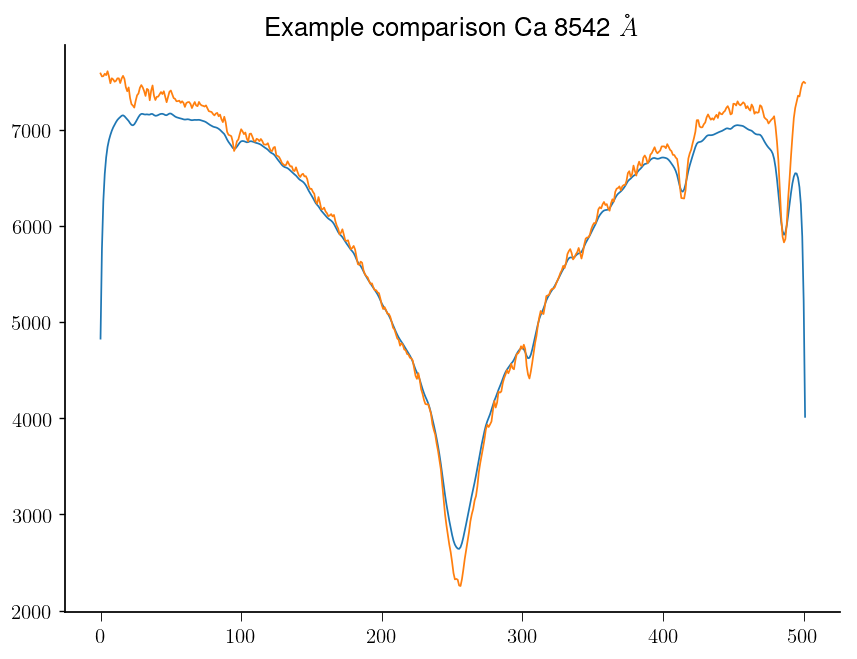

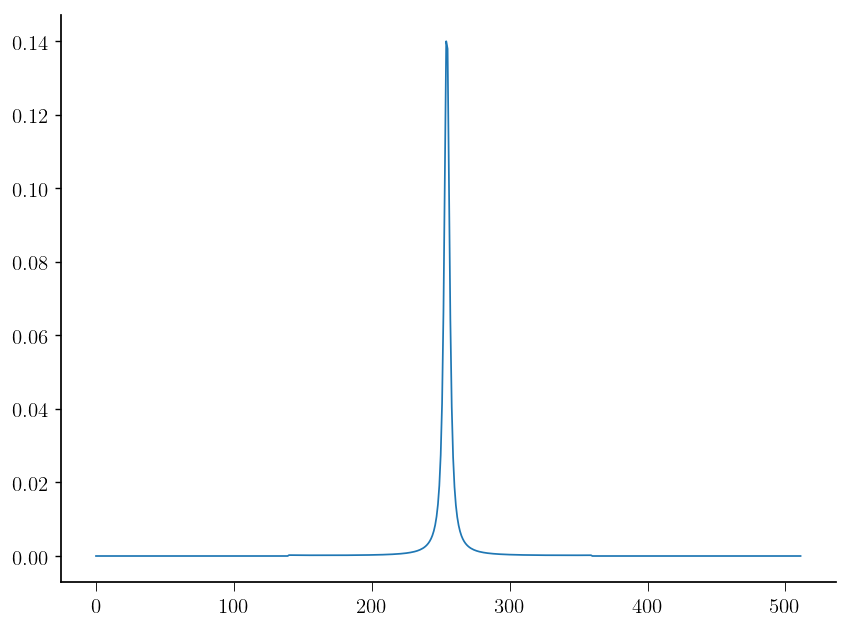

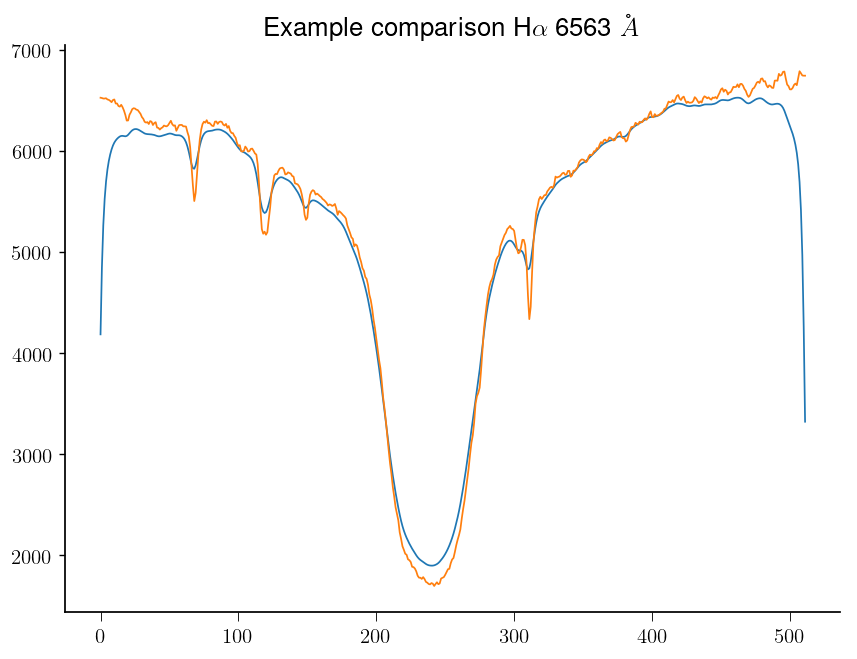

In [186]:
Nlambda_ca = caData.shape[2]
Nx_ca      = caData.shape[0]
Ny_ca      = caData.shape[1]

print(Nlambda_ca)
print(caData.shape)

TProfile = produce_FP_transmission_peak(caSpectralRes,0,Nlambda_ca,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
plt.plot(TProfile)
plt.show()
caConvolved = np.zeros((Nx_ca,Ny_ca,Nlambda_ca))

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved[ii,jj,:] = np.convolve(caData[ii,jj,:],TProfile,mode='same')

plt.title('Example comparison Ca 8542 $\AA$')
plt.plot(caConvolved[80,20,:])
plt.plot(caData[80,20,:])
plt.show()

Nlambda_ha = haData.shape[2]
Nx_ha      = haData.shape[0]
Ny_ha      = haData.shape[1]


TProfile = produce_FP_transmission_peak(haSpectralRes,0,Nlambda,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
plt.plot(TProfile)
plt.show()
haConvolved = np.zeros((Nx_ha,Ny_ha,Nlambda))

for ii in range(Nx_ha):
    for jj in range(Ny_ha):
        haConvolved[ii,jj,:] = np.convolve(haData[ii,jj,:],TProfile,mode='same')

plt.title('Example comparison H$\\alpha$ 6563 $\AA$')
plt.plot(haConvolved[80,20,:])
plt.plot(haData[80,20,:])
plt.show()

In [269]:
model = build_dense_model()
model.summary()


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 100)          0           input_18[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 128)          12928       flatten_17[0][0]                 
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 128)          16512       dense_57[0][0]                   
___________________________________________________________________________________________

In [273]:
EPOCHS = 1000
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=1e-2, beta_1=0.9,
              beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)

history = model.fit(np.reshape(caData_Conv_norm[:,:,200:300],(Nx_ca*Ny_ca,100,1)),
                    np.reshape(caData_norm[:,:,200:300],(Nx_ca*Ny_ca,100)),
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 21250 samples, validate on 3750 samples
Epoch 1/1000
21250/21250 [==============================] - 3s 140us/sample - loss: 7.9237e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 7.9237e-04 - val_loss: 7.8501e-04 - val_mean_absolute_error: 0.0209 - val_mean_squared_error: 7.8502e-04
Epoch 2/1000
21250/21250 [==============================] - 3s 162us/sample - loss: 7.9242e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 7.9242e-04 - val_loss: 7.8463e-04 - val_mean_absolute_error: 0.0209 - val_mean_squared_error: 7.8463e-04
Epoch 3/1000
21250/21250 [==============================] - 3s 139us/sample - loss: 7.9126e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 7.9126e-04 - val_loss: 7.8382e-04 - val_mean_absolute_error: 0.0208 - val_mean_squared_error: 7.8382e-04
Epoch 4/1000
15392/21250 [====================>.........] - ETA: 0s - loss: 7.9362e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 7.9362e-

KeyboardInterrupt: 

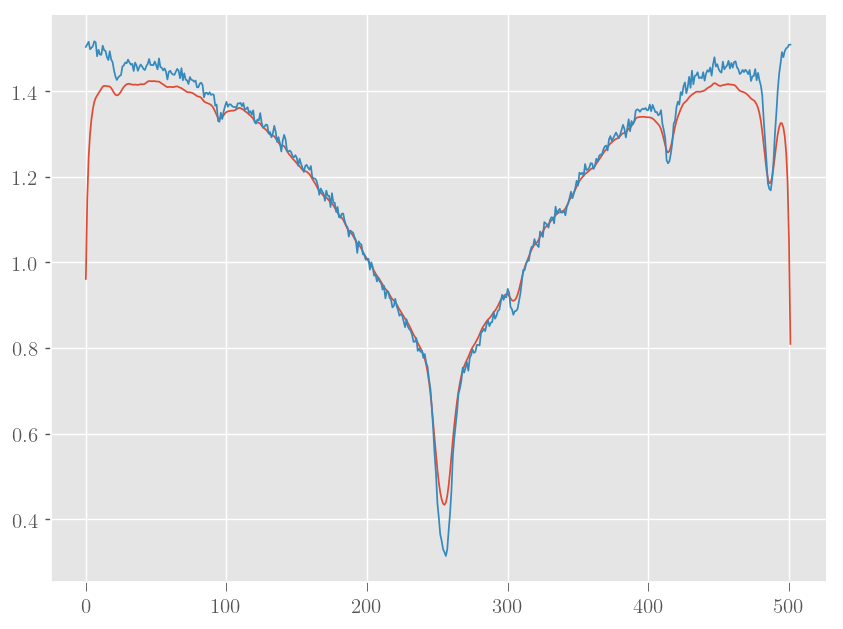

In [268]:
norm_data = np.mean(caData[:,:,200],axis=(0,1))
norm_conv = np.mean(caConvolved[:,:,200],axis=(0,1))

caData_Conv_norm = caConvolved / norm_conv 
caData_norm      = caData / norm_data 

plt.plot(caData_Conv_norm[90,90,:])
plt.plot(caData_norm[90,90,:])
plt.show()

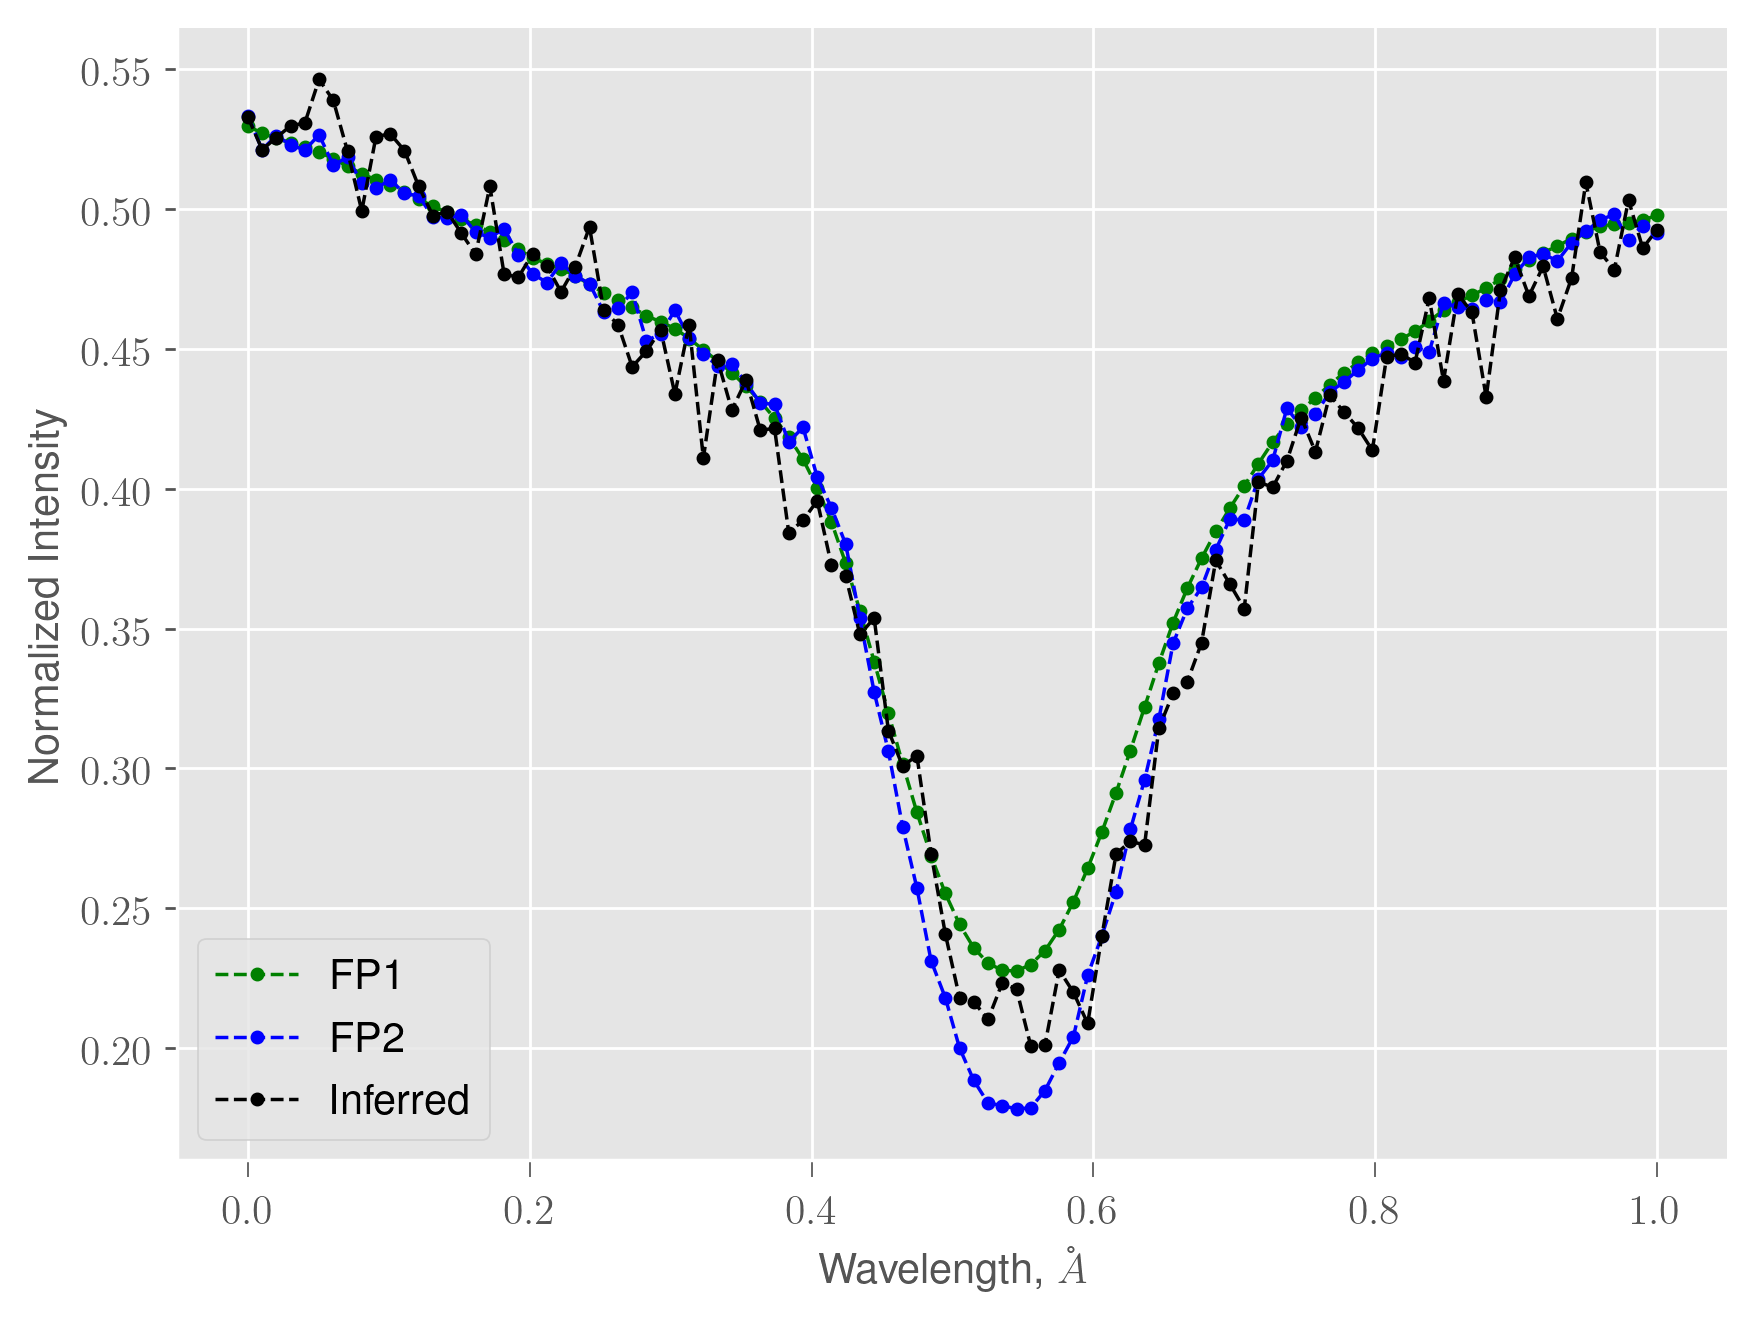

In [267]:
prevNum  = 20
delta    = 1


#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)Z
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

res = model.predict(np.reshape(caData_Conv_norm[prevNum,100,200:300],(1,100,1)))

wavescale = np.linspace(0,1,num=100)
plot_spec_profile_comparison(wavescale,caData_Conv_norm[prevNum,100,200:300],
                             caData_norm[prevNum,100,200:300],res[0,:])